## Thermally driven Convection 

Flow driven by thermal buoyancy and thermal buoyancy advected by the flow !

**New concepts:** Advection-diffusion solver template, thermal boundary conditions, Rayleigh number, analysis functions


In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import math

Setup parameters
-----

In [2]:
# Set number of dimensions.
dim = 2

# Set simulation box size.
boxHeight = 1.0
boxLength = 2.0

# Set the resolution.
res = 16

# Set min/max temperatures.

tempMin = 0.0
tempMax = 1.0

Create mesh and variables
------

The mesh object has both a primary and sub mesh. "Q1/dQ0" produces a primary mesh with element type Q1 and a sub-mesh with elements type dQ0. Q1 elements have node points at the element corners, dQ0 elements have a single node at the elements centre.

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (int(boxLength*res), res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

Tmesh = mesh

# QUESTION - will this work ?  
#
# Tmesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
#                                  elementRes  = (int(boxLength*res*4), res*4), 
#                                  minCoord    = (0., 0.), 
#                                  maxCoord    = (boxLength, boxHeight))

Create mesh variables.  Note the pressure field uses the sub-mesh, the temperature uses the same mesh at this stage. The `temperatureDotField` variable is a work array for the advection-diffusion solver.

In [4]:
velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

temperatureField    = uw.mesh.MeshVariable( mesh=Tmesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=Tmesh,         nodeDofCount=1 )

# Initialise values

velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.
temperatureDotField.data[:] = 0.

Set up material parameters and functions
-----

Set functions for viscosity, density and buoyancy force. These functions and variables only need to be defined at the beginning of the simulation, not each timestep.

In [5]:
# Set viscosity to be a constant.
viscosity = 1.

# Rayleigh number.
Ra = 1.0e4

# Construct a density function.
densityFn = Ra * temperatureField

# Define our vertical (upward) unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

Create initial & boundary conditions
----------

Set a sinusoidal perturbation in the temperature field to seed the onset of convection.

Set top and bottom wall temperature boundary values.

In [6]:
pertStrength = 0.2

deltaTemp = tempMax - tempMin

for index, coord in enumerate(Tmesh.data):
    pertCoeff = math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))

for index in Tmesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
    
for index in Tmesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

Velocity and Temperature boundary conditions


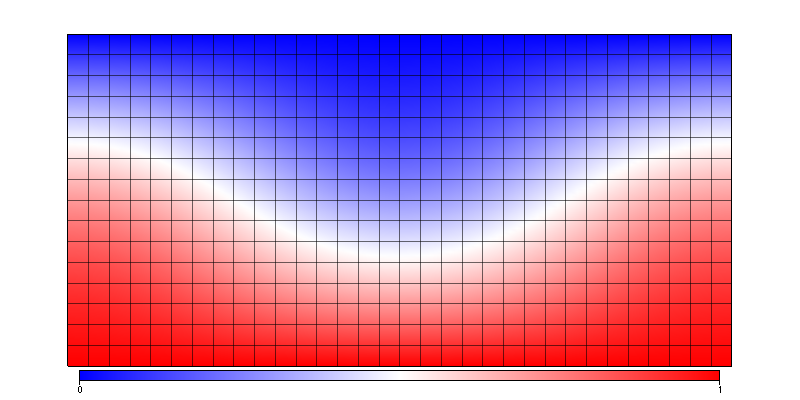

In [7]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

# 2D velocity vector can have two Dirichlet conditions on each vertex, 
# v_x is fixed on the iWalls (vertical), v_y is fixed on the jWalls (horizontal)

freeslipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls) )

# Temperature is held constant on the jWalls

jTWalls = Tmesh.specialSets["MinJ_VertexSet"] + Tmesh.specialSets["MaxJ_VertexSet"]
tempBC     = uw.conditions.DirichletCondition( variable        = temperatureField, 
                                               indexSetsPerDof = (jTWalls,) )

figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(Tmesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.Mesh(mesh, opacity=0.5) )
figtemp.append( glucifer.objects.Mesh(Tmesh , opacity=0.15) )

figtemp.show()

System setup
-----

Set up a Stokes equation template and an advection diffusion template

In [8]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = [freeslipBC,],
                            fn_viscosity  = viscosity, 
                            fn_bodyforce  = buoyancyFn )

# Implicit Stokes solver
solver = uw.systems.Solver( stokes )
solver.set_inner_method("mumps")
solver.set_penalty(1.0e7)

# advDiff uses an explicit / timestepping approach

advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField, 
                                         fn_diffusivity = 1.0, 
                                         conditions     = [tempBC,] )

Main time stepping loop
-----
Time and steps are initialised to zero. 

In [9]:
time = 0.
step = 0
steps_end = 200

while step < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)  ## <- The explicit timestep computations
    step += 1

**Plot final temperature and velocity field**


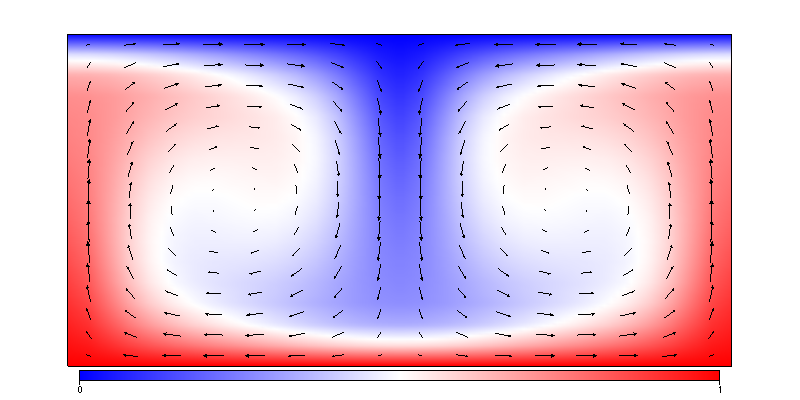

In [10]:
# plot figure
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(Tmesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, arrowHead=0.2, scaling=0.1) )
figtemp.show()